# POD and fft from pointclouds 

We will now proceed to explain how to perform POD from point clouds. In this instance, we test only for POD in serial, as to perform in parallel, a parallel reader/writer is needed.

If you have saved information in hdf5 and have habilitated mpi4py compilation of it, then you could use this code in parallel.

#### Import general modules

In [1]:
# Import required modules
from mpi4py import MPI #equivalent to the use of MPI_init() in C
import matplotlib.pyplot as plt
import numpy as np
import h5py
import sys
import os

# Get mpi info
comm = MPI.COMM_WORLD

# Hide the log for the notebook. Not recommended when running in clusters as it is better you see what happens
import os
os.environ["PYNEKTOOLS_HIDE_LOG"] = 'true'

## Set up the input parameters

In [2]:
file_sequence = [f"../4-interpolation/interpolated_fields{str(1+i).zfill(5)}.hdf5" for i in range(0, 48)]
pod_fields = ["u", "v", "w"]
mesh_fname = "../4-interpolation/points.hdf5"
mass_matrix_fname = "../4-interpolation/points.hdf5"
mass_matrix_key = "mass"
k = len(file_sequence)
p = len(file_sequence)
fft_axis = 1 # 0 for x, 1 for y, 2 for z (Depends on how the mesh was created)

## Call the pynektools routines

In [3]:
# Import the pynektools routines
from pynektools.rom.fft_pod_wrappers import pod_fourier_1_homogenous_direction, physical_space

# Perform the POD with your input data
pod, ioh, _3d_bm_shape, number_of_frequencies, N_samples = pod_fourier_1_homogenous_direction(comm, file_sequence, pod_fields, mass_matrix_fname, mass_matrix_key, k, p, fft_axis)

/home/adperez/software/pyNekTools/pynektools/rom/fft_pod_wrappers.py:365: ComplexWarning: Casting complex values to real discards the imaginary part
  ioh[kappa].bm1sqrt[:, :] = np.copy(ioh[kappa].xi[:, :])


# Write out data

Write out modes that you specify in physical space.

In [4]:
from pynektools.rom.fft_pod_wrappers import write_3dfield_to_file

# Load the mesh
with h5py.File(mesh_fname, 'r') as f:
    x = f["x"][:]
    y = f["y"][:]
    z = f["z"][:]

# Write out 5 modes for the first 3 wavenumbers
write_3dfield_to_file("pod.vtk", x, y, z, pod, ioh, wavenumbers=[k for k in range(0, 3)], modes=[i for i in range(0, 5)], field_shape=_3d_bm_shape, fft_axis=fft_axis, field_names=pod_fields, N_samples=N_samples)

# Reconstruct all the snapshots for the first 3 wavenumbers and 5 modes
write_3dfield_to_file("pod.vtk", x, y, z, pod, ioh, wavenumbers=[k for k in range(1, 3)], modes=[i for i in range(0, 5)], field_shape=_3d_bm_shape, fft_axis=fft_axis, field_names=pod_fields, N_samples=N_samples, snapshots=[i for i in range(0, len(file_sequence))])


Writing ./pod_kappa_0_mode0.vtk
Writing ./pod_kappa_0_mode1.vtk
Writing ./pod_kappa_0_mode2.vtk
Writing ./pod_kappa_0_mode3.vtk
Writing ./pod_kappa_0_mode4.vtk
Writing ./pod_kappa_1_mode0.vtk
Writing ./pod_kappa_1_mode1.vtk
Writing ./pod_kappa_1_mode2.vtk
Writing ./pod_kappa_1_mode3.vtk
Writing ./pod_kappa_1_mode4.vtk
Writing ./pod_kappa_2_mode0.vtk
Writing ./pod_kappa_2_mode1.vtk
Writing ./pod_kappa_2_mode2.vtk
Writing ./pod_kappa_2_mode3.vtk
Writing ./pod_kappa_2_mode4.vtk
Writing ./pod_reconstructed_data_0
Writing ./pod_reconstructed_data_1
Writing ./pod_reconstructed_data_2
Writing ./pod_reconstructed_data_3
Writing ./pod_reconstructed_data_4
Writing ./pod_reconstructed_data_5
Writing ./pod_reconstructed_data_6
Writing ./pod_reconstructed_data_7
Writing ./pod_reconstructed_data_8
Writing ./pod_reconstructed_data_9
Writing ./pod_reconstructed_data_10
Writing ./pod_reconstructed_data_11
Writing ./pod_reconstructed_data_12
Writing ./pod_reconstructed_data_13
Writing ./pod_reconstructe

## Save the data in fourier space

In [5]:
from pynektools.rom.fft_pod_wrappers import save_pod_state

# Save the POD state
save_pod_state("pod_state.hdf5", pod)

## Reconstruct the snapshot

Use the helper function to reconstruct the snapshots.

Here you input the results you got. For this you must specify which snapshots to reconstruct the proper keyword. Then the wavenumbers and modes in each wavenumber to be used. At the moment, the support is only to reconstruct in the same modes in all chosen wavenumbers. This can be modified later quite easily by, for example, passing a directory with modes list, just as done for POD and IOH.

In [6]:
phys = physical_space(pod, ioh, wavenumbers=[k for k in range(0, number_of_frequencies)], modes=[i for i in range(0, k)], field_shape=_3d_bm_shape, fft_axis=fft_axis, field_names=pod_fields, N_samples=N_samples, snapshots=[i for i in range(0, len(file_sequence))])

## Perform tests

First check that the reconstruction of every snapshot matches and that the energy is kept in the time coefficients, not in the modes.

In [7]:
# Load the mass matrix
with h5py.File(mass_matrix_fname, 'r') as f:
    bm_v = f["mass"][:]

# Go through the snapshots in the file sequence
total_snapshot_energy = 0
for j, fname in enumerate(file_sequence):
    print(f"Testing snapshot {j}: {fname}")
    
    with h5py.File(fname, 'r') as f:

        # Check one snapshot at a time
        # Here one could also just use the phys that has been previously computed.
        phys = physical_space(pod, ioh, wavenumbers=[k for k in range(0, number_of_frequencies)], modes=[i for i in range(0, k)], field_shape=_3d_bm_shape, fft_axis=fft_axis, field_names=pod_fields, N_samples=N_samples, snapshots=[j])

        # Check if the reconstruction is accurate
        for field in pod_fields:
            passed = np.allclose(phys[j][field], f[field][:])
            print(f"Field {field} passed: {passed}")

        # Check if the energy was accurately captured
        snapshot_energy = 0
        for field in pod_fields:
            snapshot_energy += np.sum(f[field][:]**2*bm_v)
        total_snapshot_energy += snapshot_energy

        reconstruction_energy = 0
        for kappa in range(0, number_of_frequencies):
            a_i = np.diag(pod[kappa].d_1t)@pod[kappa].vt_1t[:,j]
            reconstruction_energy += np.sum(np.abs(a_i)**2)

        print(f"Snapshot energy: {snapshot_energy}")
        print(f"Reconstruction energy: {reconstruction_energy}")
    
    print("=======================================")

# Check if the total energy is kept in the singular values
print(f"total snapshot energy: {total_snapshot_energy}")

total_pod_energy = 0
for kappa in range(0, number_of_frequencies):
    total_pod_energy += np.sum(pod[kappa].d_1t**2)
print(f"Total POD energy: {total_pod_energy}")
print("=======================================")   

Testing snapshot 0: ../4-interpolation/interpolated_fields00001.hdf5
Field u passed: True
Field v passed: True
Field w passed: True
Snapshot energy: 3.698958237844183e-05
Reconstruction energy: 3.6993163022397004e-05
Testing snapshot 1: ../4-interpolation/interpolated_fields00002.hdf5
Field u passed: True
Field v passed: True
Field w passed: True
Snapshot energy: 3.8898814924962444e-05
Reconstruction energy: 3.8902239959461035e-05
Testing snapshot 2: ../4-interpolation/interpolated_fields00003.hdf5
Field u passed: True
Field v passed: True
Field w passed: True
Snapshot energy: 4.153454569587408e-05
Reconstruction energy: 4.153817337208489e-05
Testing snapshot 3: ../4-interpolation/interpolated_fields00004.hdf5
Field u passed: True
Field v passed: True
Field w passed: True
Snapshot energy: 4.4425076415412405e-05
Reconstruction energy: 4.442864337674737e-05
Testing snapshot 4: ../4-interpolation/interpolated_fields00005.hdf5
Field u passed: True
Field v passed: True
Field w passed: True


Then check if the left and right singular vectors are indeed orthogonal with respect to the others along the wavenumbers

In [8]:
from pynektools.rom.fft_pod_wrappers import degenerate_scaling

# Check the left singular vectors
all_passed = True
for kappa in range(0, number_of_frequencies):
    
    kappa_i = 0
    kappa_j = kappa_i # These are the modes for the fourier coefficients. Thus, they orthogonals in a wave number. The fourier modes are orthogonal among fourier modes

    for i in range(0, k):
        for j in range(0, k):

            passed = True

            scaled_mode_i = pod[kappa_i].u_1t[:,i]*ioh[kappa_i].bm1sqrt[:,0]*degenerate_scaling(kappa_i)
            scaled_mode_j = pod[kappa_j].u_1t[:,j]*ioh[kappa_j].bm1sqrt[:,0]*degenerate_scaling(kappa_j)

            norm = np.abs(scaled_mode_i.T@scaled_mode_j)

            if (j==i) and (np.allclose(norm, 1)):
                passed = True
            elif (j!=i) and (np.allclose(norm, 0)):
                passed = True
            else:
                passed = False

            if not passed:              
                print(f"Mode {i} and mode {j} in wavenumber {kappa} are not orthogonal")
                print(f"Norm: {norm}")
                all_passed = False
                break

print(f"The modes are orthogonal: {all_passed}")

# Check the right singular vectors
all_passed = True
for kappa in range(0, number_of_frequencies):
    
    kappa_i = 0
    kappa_j = kappa_i # These are the modes for the fourier coefficients. Thus, they orthogonals in a wave number. The fourier modes are orthogonal among fourier modes

    for i in range(0, k):
        for j in range(0, k):

            passed = True

            scaled_mode_i = pod[kappa_i].vt_1t[i,:]
            scaled_mode_j = pod[kappa_j].vt_1t[j,:]

            norm = np.abs(scaled_mode_i.T@scaled_mode_j)

            if (j==i) and (np.allclose(norm, 1)):
                passed = True
            elif (j!=i) and (np.allclose(norm, 0)):
                passed = True
            else:
                passed = False

            if not passed:              
                print(f"Right singular vector {i} and right singular vector {j} in wavenumber {kappa} are not orthogonal")
                print(f"Norm: {norm}")
                all_passed = False
                break

print(f"The right singular vectors are orthogonal: {all_passed}")

The modes are orthogonal: True
The right singular vectors are orthogonal: True


## Visualize the data

We have already written the data to vtk in previous steps. This means that you can readily use paraview or visit, for example.

However one can also plot the data in python. For this we use the pyvista module.

First we can get a dictionary with the reconstruction of the snapshots and also the modes in physical space.

In [9]:
phys = physical_space(pod, ioh, wavenumbers=[k for k in range(0, number_of_frequencies)], modes=[i for i in range(0, k)], field_shape=_3d_bm_shape, fft_axis=fft_axis, field_names=pod_fields, N_samples=N_samples, snapshots=[i for i in range(0, len(file_sequence))])
phys_modes = physical_space(pod, ioh, wavenumbers=[k for k in range(0, number_of_frequencies)], modes=[i for i in range(0, k)], field_shape=_3d_bm_shape, fft_axis=fft_axis, field_names=pod_fields, N_samples=N_samples)

Then we can start plotting!

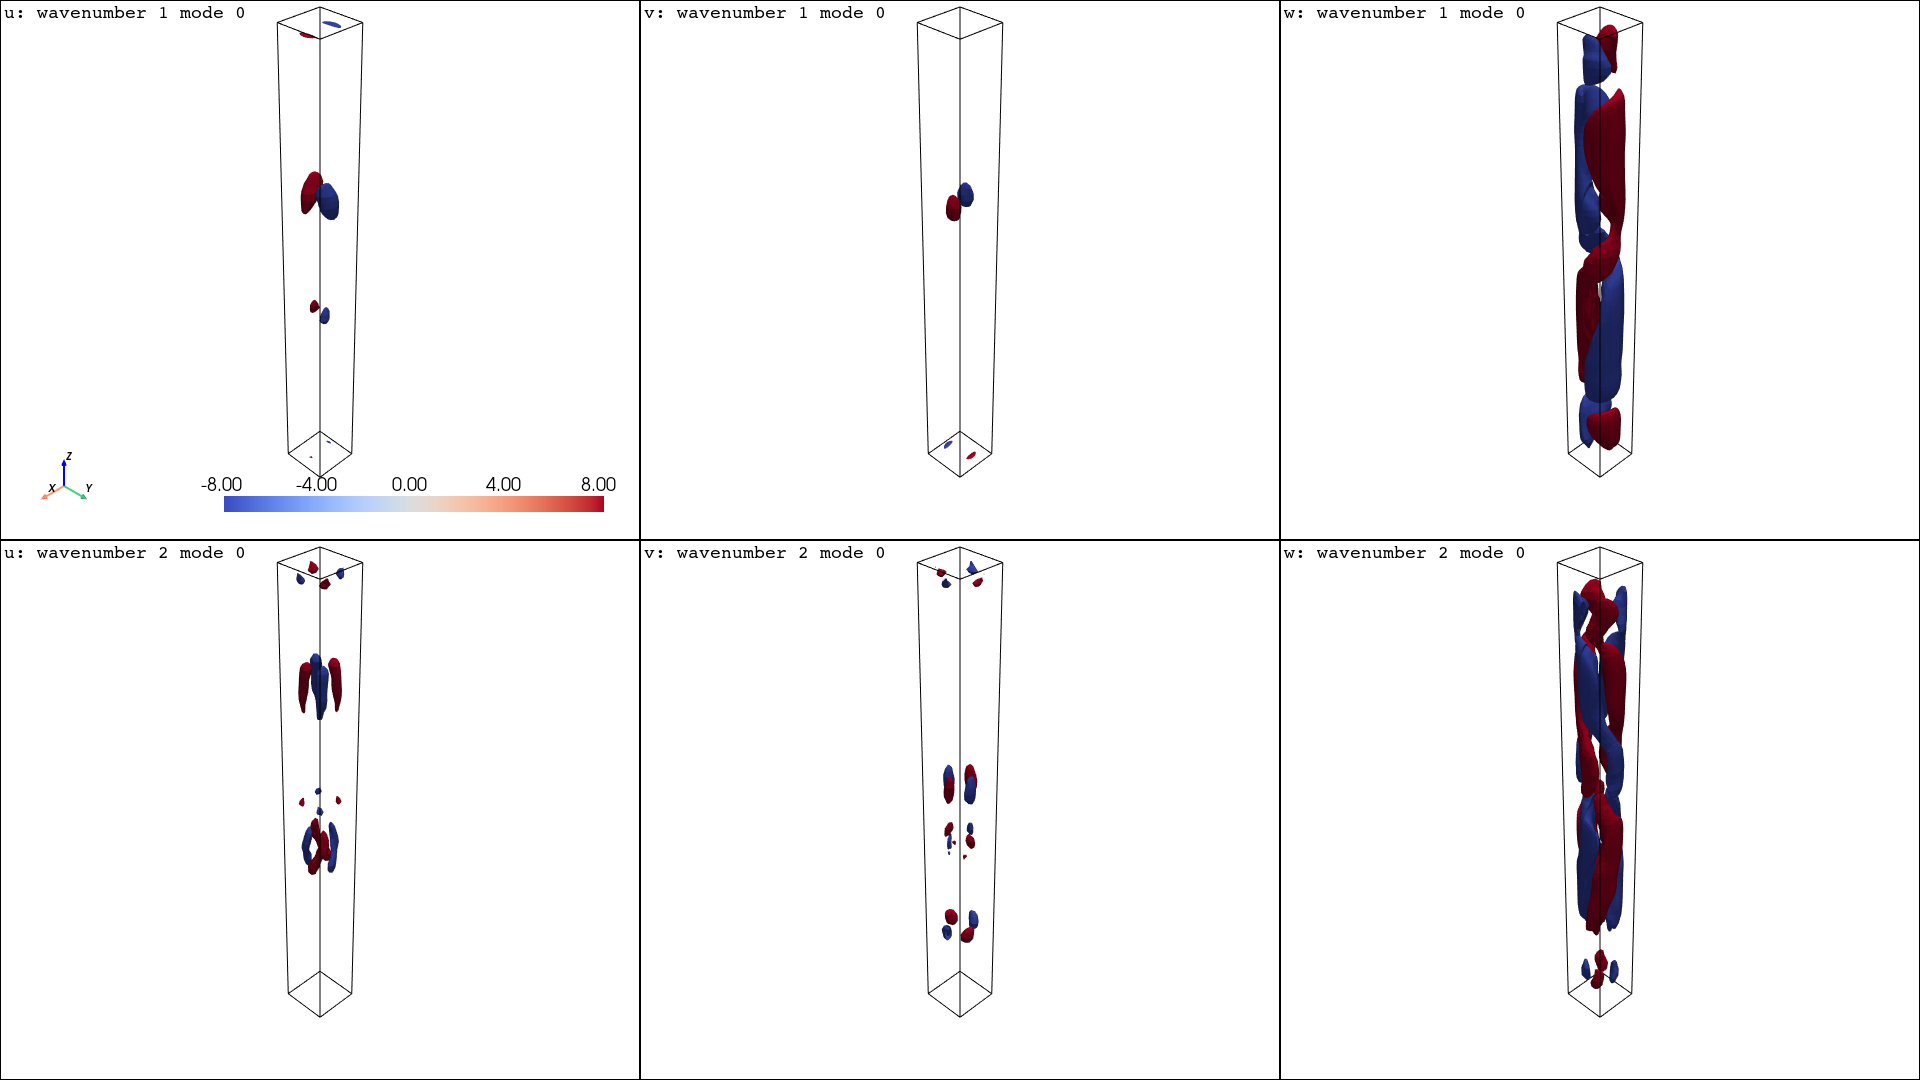

In [11]:
import pyvista as pv

# Input parameters
kappa = 1
mode = 0
fields = ["u","v","w"]
isosurfaces = np.array([-8, 8])

# Create a structured mesh
mesh_1 = pv.StructuredGrid(x, y, z)
mesh_2 = pv.StructuredGrid(x, y, z)

# Add the field to the mesh
for field in fields:
    values = phys_modes[kappa][mode][field]
    mesh_1.point_data[field] = values.ravel(order='F')
    values2 = phys_modes[kappa+1][mode][field]
    mesh_2.point_data[field] = values2.ravel(order='F')

# Plot
pl = pv.Plotter(shape=(2, 3), window_size=[1920,1080]) # Size in pixels
pl.add_axes()
for i, field in enumerate(fields):
    
    # Plot first row
    pl.subplot(0, i)
    # Obtain the isosurfaces
    isos = mesh_1.contour(scalars = field, isosurfaces = isosurfaces)
    pl.add_mesh(mesh_1.outline(), color="k")
    pl.add_mesh(isos, opacity=1, cmap="coolwarm", scalar_bar_args={'title': f""})
 
    # Change the settings a bit
    pl.add_text(f"{field}: wavenumber {kappa} mode {mode}", font = "courier", font_size=10, position="upper_left")
    
    # Plot second row
    pl.subplot(1, i)
    # Obtain the isosurfaces
    isos = mesh_2.contour(scalars = field, isosurfaces = isosurfaces)
    pl.add_mesh(mesh_2.outline(), color="k")
    pl.add_mesh(isos, opacity=1, cmap="coolwarm", scalar_bar_args={'title': f""})
 
    # Change the settings a bit
    pl.add_text(f"{field}: wavenumber {kappa+1} mode {mode}", font = "courier", font_size=10, position="upper_left")

# Capture the plot as an image and show it (This is just to make the notebook render better on github)
from IPython.display import Image, display
image_path = "static_plot.png"
pl.screenshot(image_path)
pl.close()
display(Image(filename=image_path))
#pl.show()